# <center>**Selecting the most reading city and region in Russia**</center>

## 1. Problem and background description

For this project, we will assume that the Ministry of Culture of Russia is planning a campain to stimulate population's interest towards reading. Several measures are being designed, and one of them is to create a rating of the "most reading" cities and regions (the idea came out upon the success of other ratings such as "100 best places in Russia" or "Name of Russia" for the emblematic characters of Russian history). 

Russia has the world's biggest territory of 17 098 246 km² divided into 85 regions. There are 146 745 098 inhabitants in the country, which makes Russia only the 9th most populated country in the world. Approximately 75% of the population of Russia is concentrated in its cities.

## 2. Methodology description and gathering of the data needed

**Preliminary note**: if the project was indeed realized on behalf of the ministery, it would be using other data - more official for the data on cities, regions and their population, and more local for the bookstores and libraries data (e.g. Yandex maps). 

For the present project, we will use the following data:
* list of 1117 Russian cities and their population available at: https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8
* list of 85 Russian regions and their population available at: https://ru.wikipedia.org/wiki/%D0%A1%D1%83%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B9_%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8
* data on bookstores and libraries location provided by Foursquare API.
* we also need russian cities and regions geolocalisation data: https://on55.ru/articles/2.

The downside of these data is that we would only be looking at physical stores, while today the number of people bying physical and e-books online is steadily increasing. To take this into account, we could try to connect to our analysis data on the visits to sites of top Russian book retailers as available at: https://radar.yandex.ru/top_list?thematic=retail%2Cbooks (this will not be realized in the framework of the present notebook).

In our project we will aim to analyse the concentration of book shops and libraries in the cities in relation to the number of inhabitants, as well as the inhabitant's interest to the most popular online bookstores in Russia. We will then compare the cities between them using k-mean clustering and map the resulting clusters.

To establish the most reading region of Russia, we will use the data we obtained for the cities located in each region, and will also need to account for the rural population pertaining to the region. We will account for rural population wheter by using data of connection to the online bookstores, or by using some assumptions.

Let's start by scrapping Wikipedia pages and convert regions and cities data in dataframe format.

In [1]:
# Collecting data on the cities
import pandas as pd
# Reading the content of the web page (result = list of dataframes)
WebPage_cities = pd.read_html("https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8")
# Selecting from the list the item corresponding to the cities table and storing it as df
RU_cities = WebPage_cities[1]
RU_cities.reset_index(drop=True, inplace=True)
RU_cities.columns

MultiIndex(levels=[['Города Российской Федерации'], ['Герб', 'Город', 'Население', 'Основание илипервое упоминание', 'Прежние названия', 'Регион', 'Статус города[5]', 'Федеральный округ', '№']],
           codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0], [8, 0, 1, 5, 7, 2, 3, 6, 4]])

In [2]:
#We discover that the resulting dataframe is multilevel. There is no reason for us to keep it.
RU_cities.columns = [col[1] for col in RU_cities.columns]
RU_cities

,№,Герб,Город,Регион,Федеральный округ,Население,Основание илипервое упоминание,Статус города[5],Прежние названия
0,1,NaN,Абаза,Хакасия,Сибирский,17111,1867,1966,"Абаканский Завод, Абаканско-Заводское"
1,2,NaN,Абакан,Хакасия,Сибирский,165183,1734,1931,Усть-Абаканское (до 1931)
2,3,NaN,Абдулино,Оренбургская область,Приволжский,20663,1795,1923,NaN
3,4,NaN,Абинск,Краснодарский край,Южный,34926,1863,1963,Абинское (до 1863);Абинская (до 1962)
4,5,NaN,Агидель,Башкортостан,Приволжский,16365,1980,1991,NaN
5,6,NaN,Агрыз,Татарстан,Приволжский,19299,1646,1938,NaN
6,7,NaN,Адыгейск,Адыгея,Южный,12689,1969,1976,Адыгейский (до 1976);Теучежск (до 1990)
7,8,NaN,Азнакаево,Татарстан,Приволжский,34859,1762,1987,NaN
8,9,NaN,Азов,Ростовская область,Южный,82882,1067,1708,"Азак, Тана"
9,10,NaN,Ак-Довурак,Тыва,Сибирский,13469,1964,1964,NaN


In [3]:
# We only need to keep information on "Город" (name of the city), "Регион" (region), "Федеральный округ" (macro region) and "Население" (population).
# Dropping of all the other columns
RU_cities = RU_cities[["Город","Регион","Федеральный округ","Население"]]
RU_cities.head()

,Город,Регион,Федеральный округ,Население
0,Абаза,Хакасия,Сибирский,17111
1,Абакан,Хакасия,Сибирский,165183
2,Абдулино,Оренбургская область,Приволжский,20663
3,Абинск,Краснодарский край,Южный,34926
4,Агидель,Башкортостан,Приволжский,16365


In [4]:
RU_cities.shape

(1117, 4)

This looks better: we only have kept the information of interest, while keeping all the 1117 cities. Let's replicate the analysis to retrieve the information on regions and population.

In [5]:
# Reading the content of the web page (result = list of dataframes)
WebPage_regions = pd.read_html("https://ru.wikipedia.org/wiki/%D0%A1%D1%83%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B9_%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8")
# Selecting from the list the item corresponding to the regions table and storing it as df
RU_regions = WebPage_regions[4]
RU_regions

,№,Субъект Российской Федерации,Флаг,Герб,Терри-тория (км²),Население1.01.2020[14],Административный центр/столица,Административно-территориальное деление(согласно ОКАТО),Код ОКАТО,Муниципальные образования,Административно-территориальное деление (подробно)
0,NaN,Республики,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,Республика Адыгея,NaN,NaN,7792.0,↗463 453,Майкоп,7 районов и 2 города,79,"7 муниципальных районов, 2 городских округа",подробнее
2,2.0,Республика Алтай,NaN,NaN,92903.0,↗220 140,Горно-Алтайск,10 районов и 1 город,84,"10 муниципальных районов, 1 городской округ",подробнее
3,3.0,Республика Башкортостан,NaN,NaN,142947.0,↘4 037 811,Уфа,54 района и 21 город,80,"54 муниципальных района, 9 городских округов",подробнее
4,4.0,Республика Бурятия,NaN,NaN,351334.0,↗986 109,Улан-Удэ,21 район и 2 города,81,"21 муниципальный район, 2 городских округа",подробнее
5,5.0,Республика Дагестан,NaN,NaN,50270.0,↗3 111 353,Махачкала,41 район и 10 городов,82,"42 муниципальных района, 10 городских округов",подробнее
6,6.0,Республика Ингушетия,NaN,NaN,3123.0,↗506 688,Магас,4 района и 4 города,26,"4 муниципальных района, 4 городских округа",подробнее
7,7.0,Кабардино-Балкарская Республика,NaN,NaN,12470.0,↗868 174,Нальчик,10 районов и 3 города,83,"10 муниципальных районов, 3 городских округа",подробнее
8,8.0,Республика Калмыкия,NaN,NaN,74731.0,↘271 035,Элиста,13 районов и 1 город,85,"13 муниципальных районов, 1 городской округ",подробнее
9,9.0,Карачаево-Черкесская Республика,NaN,NaN,14277.0,↗465 669,Черкесск,10 районов и 2 города,91,"10 муниципальных районов, 2 городских округа",подробнее


In [6]:
# Keeping only the interesting information: region name, population and region center
RU_regions = RU_regions[["Субъект Российской Федерации","Население1.01.2020[14]","Административный центр/столица"]]
RU_regions

,Субъект Российской Федерации,Население1.01.2020[14],Административный центр/столица
0,Республики,NaN,NaN
1,Республика Адыгея,↗463 453,Майкоп
2,Республика Алтай,↗220 140,Горно-Алтайск
3,Республика Башкортостан,↘4 037 811,Уфа
4,Республика Бурятия,↗986 109,Улан-Удэ
5,Республика Дагестан,↗3 111 353,Махачкала
6,Республика Ингушетия,↗506 688,Магас
7,Кабардино-Балкарская Республика,↗868 174,Нальчик
8,Республика Калмыкия,↘271 035,Элиста
9,Карачаево-Черкесская Республика,↗465 669,Черкесск


There is a problem with this data: we have 92 rows, but we know from the scrapped page that there are only 85 regions in Russia. Indeed, some rows are just the names of categories and contain "Nan". We need to drop these, as well as the last row which is total (we might use this information later, so we'll store it in a separate df.

In [7]:
RU_regions = RU_regions.dropna()
RU_total = RU_regions.tail(1)
RU_regions = RU_regions.drop(91)
RU_regions

,Субъект Российской Федерации,Население1.01.2020[14],Административный центр/столица
1,Республика Адыгея,↗463 453,Майкоп
2,Республика Алтай,↗220 140,Горно-Алтайск
3,Республика Башкортостан,↘4 037 811,Уфа
4,Республика Бурятия,↗986 109,Улан-Удэ
5,Республика Дагестан,↗3 111 353,Махачкала
6,Республика Ингушетия,↗506 688,Магас
7,Кабардино-Балкарская Республика,↗868 174,Нальчик
8,Республика Калмыкия,↘271 035,Элиста
9,Карачаево-Черкесская Республика,↗465 669,Черкесск
10,Республика Карелия,↘614 628,Петрозаводск


Last preparation step - let's obtain latitude and longitude data, using a build-in function of IBM Watson Studio.

In [8]:
# The code was removed by Watson Studio for sharing.

,Город,Регион,Федеральный округ,lat,lng
0,Абаза,Хакасия,Сибирский,52.651657,90.088572
1,Абакан,Хакасия,Сибирский,53.721152,91.442387
2,Абдулино,Оренбургская область,Приволжский,53.677839,53.647263
3,Абинск,Краснодарский край,Южный,44.866256,38.151163
4,Агидель,Башкортостан,Приволжский,55.899835,53.922040


As the free account on Foursquare has some limitations, we will, in the first time, limit our analysis by looking only to the region's capital cities. To do so, we will merge the regions table with the LatLong data.

In [9]:
Data = RU_regions.merge(LatLong,how='left', left_on='Административный центр/столица',right_on='Город')
Data.head()

,Субъект Российской Федерации,Население1.01.2020[14],Административный центр/столица,Город,Регион,Федеральный округ,lat,lng
0,Республика Адыгея,↗463 453,Майкоп,Майкоп,Адыгея,Южный,44.608865,40.098548
1,Республика Алтай,↗220 140,Горно-Алтайск,Горно-Алтайск,Алтай,Сибирский,51.958182,85.960373
2,Республика Башкортостан,↘4 037 811,Уфа,Уфа,Башкортостан,Приволжский,54.735147,55.958727
3,Республика Бурятия,↗986 109,Улан-Удэ,Улан-Удэ,Бурятия,Сибирский,51.834464,107.584574
4,Республика Дагестан,↗3 111 353,Махачкала,Махачкала,Дагестан,Северо-Кавказский,42.983060,47.504682


In [19]:
Data = Data.dropna()
Data.shape

(81, 8)

## 3. Analysis

We want to analyse book shops and libraries density in Russia (we start with the assumption that these are mostly concentrated in the cities). To do so, we browse the list of venues types available at https://developer.foursquare.com/docs/resources/categories and identify categories we are interested in:
* university bookstores: "4bf58dd8d48988d1b1941735",    
* university libraries: "4bf58dd8d48988d1a7941735",
* bookstores: "4bf58dd8d48988d114951735",
* libraries: "4bf58dd8d48988d12f941735".    
Actually, the first two categories might introduce some biais in our analysis, because the cities with universities could be favoured by this rating. We will conclude on use of these data upon loading them from Foursquare.

Since, after several trials, the query with all the four venue types at the same time does not seem to work, we will first get one table by venue type, and then concatenate data.

In [10]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

We will communicate the identifiers to connect to the Foursquare API.

In [11]:
# The code was removed by Watson Studio for sharing.

Your credentiаls:
CLIENT_ID: ok
CLIENT_SECRET: ok


In [34]:
# 1.1 Define function to collect libraries data
def getLibraries(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            '4bf58dd8d48988d12f941735')
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [35]:
# 1.2. Run the function to collect libraries data
RU_Libraries = getLibraries (names=Data['Город'],
                                   latitudes=Data['lat'],
                                   longitudes=Data['lng'])

Майкоп
Горно-Алтайск
Уфа
Улан-Удэ
Махачкала
Магас
Нальчик
Элиста
Черкесск
Петрозаводск
Сыктывкар
Йошкар-Ола
Саранск
Якутск
Владикавказ
Казань
Кызыл
Ижевск
Абакан
Грозный
Чебоксары
Барнаул
Чита
Петропавловск-Камчатский
Краснодар
Красноярск
Пермь
Владивосток
Ставрополь
Хабаровск
Благовещенск
Благовещенск
Архангельск
Астрахань
Белгород
Брянск
Владимир
Волгоград
Вологда
Воронеж
Иваново
Иркутск
Калининград
Калуга
Кемерово
Киров
Киров
Кострома
Курган
Курск
Липецк
Магадан
Мурманск
Новосибирск
Омск
Оренбург
Орёл
Пенза
Псков
Ростов-на-Дону
Рязань
Самара
Саратов
Южно-Сахалинск
Екатеринбург
Смоленск
Тамбов
Тверь
Томск
Тула
Тюмень
Ульяновск
Челябинск
Ярославль
Москва
Санкт-Петербург
Биробиджан
Нарьян-Мар
Ханты-Мансийск
Анадырь
Салехард


In [40]:
# 1.3. Verify the libraries dataframe
print(RU_Libraries.head(10))
RU_Libraries.shape

         City  City Latitude  City Longitude  \
0    Улан-Удэ      51.834464      107.584574   
1   Махачкала      42.983060       47.504682   
2      Элиста      46.307743       44.269759   
3      Элиста      46.307743       44.269759   
4   Сыктывкар      61.668793       50.836399   
5   Сыктывкар      61.668793       50.836399   
6   Сыктывкар      61.668793       50.836399   
7   Сыктывкар      61.668793       50.836399   
8  Йошкар-Ола      56.630842       47.886089   
9     Саранск      54.187433       45.183938   

                                        Venue  Venue Latitude  Venue Longitude  
0  Национальная библиотека Республики Бурятия       51.832795       107.581800  
1                      Центральная библиотека       42.981865        47.508198  
2                                     КИГИРАН       46.305684        44.267201  
3                   Библиотека Им Амур-Санана       46.305093        44.267520  
4                 Библиотека им. С.Я. Маршака       61.670162     

(123, 6)

In [41]:
# 2.1 Define function to collect bookstores data
def getBookstores(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            '4bf58dd8d48988d114951735')
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [42]:
# 2.2 Run the function to collect bookstores data
RU_Bookstores = getBookstores (names=Data['Город'],
                                   latitudes=Data['lat'],
                                   longitudes=Data['lng'])

Майкоп
Горно-Алтайск
Уфа
Улан-Удэ
Махачкала
Магас
Нальчик
Элиста
Черкесск
Петрозаводск
Сыктывкар
Йошкар-Ола
Саранск
Якутск
Владикавказ
Казань
Кызыл
Ижевск
Абакан
Грозный
Чебоксары
Барнаул
Чита
Петропавловск-Камчатский
Краснодар
Красноярск
Пермь
Владивосток
Ставрополь
Хабаровск
Благовещенск
Благовещенск
Архангельск
Астрахань
Белгород
Брянск
Владимир
Волгоград
Вологда
Воронеж
Иваново
Иркутск
Калининград
Калуга
Кемерово
Киров
Киров
Кострома
Курган
Курск
Липецк
Магадан
Мурманск
Новосибирск
Омск
Оренбург
Орёл
Пенза
Псков
Ростов-на-Дону
Рязань
Самара
Саратов
Южно-Сахалинск
Екатеринбург
Смоленск
Тамбов
Тверь
Томск
Тула
Тюмень
Ульяновск
Челябинск
Ярославль
Москва
Санкт-Петербург
Биробиджан
Нарьян-Мар
Ханты-Мансийск
Анадырь
Салехард


In [43]:
# 2.3 Verify the bookstores dataframe
print(RU_Bookstores.head(10))
RU_Bookstores.shape

            City  City Latitude  City Longitude                   Venue  \
0         Майкоп      44.608865       40.098548                   Чехов   
1         Майкоп      44.608865       40.098548   книжный магазин Факел   
2  Горно-Алтайск      51.958182       85.960373                 Book'ля   
3  Горно-Алтайск      51.958182       85.960373            Альтернатива   
4  Горно-Алтайск      51.958182       85.960373                  Знайка   
5            Уфа      54.735147       55.958727             Читай-город   
6            Уфа      54.735147       55.958727             Читай-город   
7       Улан-Удэ      51.834464      107.584574  Полином на Сухэ-Батора   
8       Улан-Удэ      51.834464      107.584574                   Книги   
9       Улан-Удэ      51.834464      107.584574                   Книги   

   Venue Latitude  Venue Longitude  
0       44.607498        40.095413  
1       44.608243        40.102736  
2       51.958363        85.959606  
3       51.957265        8

(208, 6)

In [44]:
# 3.1 Define function to collect university libraries data
def getUniLib(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            '4bf58dd8d48988d1a7941735')
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [45]:
# 3.2 Run the function to collect university libraries data
RU_UniLib = getUniLib (names=Data['Город'],
                                   latitudes=Data['lat'],
                                   longitudes=Data['lng'])

Майкоп
Горно-Алтайск
Уфа
Улан-Удэ
Махачкала
Магас
Нальчик
Элиста
Черкесск
Петрозаводск
Сыктывкар
Йошкар-Ола
Саранск
Якутск
Владикавказ
Казань
Кызыл
Ижевск
Абакан
Грозный
Чебоксары
Барнаул
Чита
Петропавловск-Камчатский
Краснодар
Красноярск
Пермь
Владивосток
Ставрополь
Хабаровск
Благовещенск
Благовещенск
Архангельск
Астрахань
Белгород
Брянск
Владимир
Волгоград
Вологда
Воронеж
Иваново
Иркутск
Калининград
Калуга
Кемерово
Киров
Киров
Кострома
Курган
Курск
Липецк
Магадан
Мурманск
Новосибирск
Омск
Оренбург
Орёл
Пенза
Псков
Ростов-на-Дону
Рязань
Самара
Саратов
Южно-Сахалинск
Екатеринбург
Смоленск
Тамбов
Тверь
Томск
Тула
Тюмень
Ульяновск
Челябинск
Ярославль
Москва
Санкт-Петербург
Биробиджан
Нарьян-Мар
Ханты-Мансийск
Анадырь
Салехард


In [46]:
# 3.3 Verify the university libraries dataframe
print(RU_UniLib.head(10))
RU_UniLib.shape

           City  City Latitude  City Longitude  \
0      Улан-Удэ      51.834464      107.584574   
1      Улан-Удэ      51.834464      107.584574   
2      Улан-Удэ      51.834464      107.584574   
3      Улан-Удэ      51.834464      107.584574   
4  Петрозаводск      61.785017       34.346878   
5  Петрозаводск      61.785017       34.346878   
6     Сыктывкар      61.668793       50.836399   
7    Йошкар-Ола      56.630842       47.886089   
8    Йошкар-Ола      56.630842       47.886089   
9    Йошкар-Ола      56.630842       47.886089   

                                             Venue  Venue Latitude  \
0         Библиотеке на 4 этаже нового корпуса БГУ       51.834585   
1           Библиотека на 4 этаже Новый корпус БГУ       51.834053   
2                 Читальный зал института Конфуция       51.834343   
3  Библиотека на первом этаже Главного корпуса БГУ       51.834321   
4                Библиотека теоретического корпуса       61.782982   
5                        Науч

(47, 6)

In [47]:
# 4.1 Define function to collect university bookstores data
def getUniStore(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            '4bf58dd8d48988d1b1941735')
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [48]:
# 4.2 Run the function to collect university bookstores data
RU_UniStore = getUniStore (names=Data['Город'],
                                   latitudes=Data['lat'],
                                   longitudes=Data['lng'])

Майкоп
Горно-Алтайск
Уфа
Улан-Удэ
Махачкала
Магас
Нальчик
Элиста
Черкесск
Петрозаводск
Сыктывкар
Йошкар-Ола
Саранск
Якутск
Владикавказ
Казань
Кызыл
Ижевск
Абакан
Грозный
Чебоксары
Барнаул
Чита
Петропавловск-Камчатский
Краснодар
Красноярск
Пермь
Владивосток
Ставрополь
Хабаровск
Благовещенск
Благовещенск
Архангельск
Астрахань
Белгород
Брянск
Владимир
Волгоград
Вологда
Воронеж
Иваново
Иркутск
Калининград
Калуга
Кемерово
Киров
Киров
Кострома
Курган
Курск
Липецк
Магадан
Мурманск
Новосибирск
Омск
Оренбург
Орёл
Пенза
Псков
Ростов-на-Дону
Рязань
Самара
Саратов
Южно-Сахалинск
Екатеринбург
Смоленск
Тамбов
Тверь
Томск
Тула
Тюмень
Ульяновск
Челябинск
Ярославль
Москва
Санкт-Петербург
Биробиджан
Нарьян-Мар
Ханты-Мансийск
Анадырь
Салехард


In [49]:
# 4.3 Verify the university libraries dataframe
print(RU_UniStore.head(10))
RU_UniStore.shape

    City  City Latitude  City Longitude           Venue  Venue Latitude  \
0  Пермь      58.010374       56.229398  инвалидка мака       58.011024   

   Venue Longitude  
0        56.237698  


(1, 6)

In [50]:
# Concatenating the four resulting tables
frames = [RU_Libraries,RU_Bookstores,RU_UniLib,RU_UniStore]
Books = pd.concat(frames)
Books.head(10)

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude
0,Улан-Удэ,51.834464,107.584574,Национальная библиотека Республики Бурятия,51.832795,107.581800
1,Махачкала,42.983060,47.504682,Центральная библиотека,42.981865,47.508198
2,Элиста,46.307743,44.269759,КИГИРАН,46.305684,44.267201
3,Элиста,46.307743,44.269759,Библиотека Им Амур-Санана,46.305093,44.267520
4,Сыктывкар,61.668793,50.836399,Библиотека им. С.Я. Маршака,61.670162,50.838303
5,Сыктывкар,61.668793,50.836399,Центральная городская библиотека,61.666221,50.838769
6,Сыктывкар,61.668793,50.836399,Национальная Библиотека РК,61.672016,50.837335
7,Сыктывкар,61.668793,50.836399,Переход СЛИ,61.672112,50.834441
8,Йошкар-Ола,56.630842,47.886089,Национальная библиотека им. С.Г. Чавайна,56.634117,47.889833
9,Саранск,54.187433,45.183938,ДРБ,54.185965,45.182551


In [51]:
Books.shape

(379, 6)

Now we have all the data on books-related locations (known by Foursquare app) in the major cities of Russia. For the "Most reading city" rating's purpose, we cannot simply compare the number of such locations (because this way logically the biggest and most popular cities will be on the top of the rating), but rather we need to make the cities comparable by calculating the proportion of books-related locations to the city's population.

In [59]:
# Calculating the number of books-related location per city
Locations = pd.pivot_table(Books, index = 'City', aggfunc = pd.Series.nunique)
Locations.head()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude
City,,,,,
Абакан,1.0,1.0,4,4.0,4.0
Архангельск,1.0,1.0,4,4.0,4.0
Астрахань,1.0,1.0,5,5.0,5.0
Барнаул,1.0,1.0,12,12.0,12.0
Белгород,1.0,1.0,3,3.0,3.0


In [62]:
Locations = Locations[['Venue']]
Locations

,Venue
City,
Абакан,4
Архангельск,4
Астрахань,5
Барнаул,12
Белгород,3
Биробиджан,2
Брянск,5
Владивосток,8
Владикавказ,2


In [75]:
# Importing the information on cities' population (and lat long values as we might want to show the results on a map later)
City_books = Locations.merge(Data, how='left', left_on='City', right_on = 'Город')
City_books

,Venue,Субъект Российской Федерации,Население1.01.2020[14],Административный центр/столица,Город,Регион,Федеральный округ,lat,lng
0,4,Республика Хакасия,↘534 186,Абакан,Абакан,Хакасия,Сибирский,53.721152,91.442387
1,4,Архангельская область[7],↘1 136 387,Архангельск,Архангельск,Архангельская область,Северо-Западный,64.539393,40.516939
2,5,Астраханская область,↘1 005 967,Астрахань,Астрахань,Астраханская область,Южный,46.347869,48.033574
3,12,Алтайский край,↘2 317 052,Барнаул,Барнаул,Алтайский край,Сибирский,53.346785,83.776856
4,3,Белгородская область,↗1 547 532,Белгород,Белгород,Белгородская область,Центральный,50.595660,36.587223
5,2,Еврейская АО,↘158 381,Биробиджан,Биробиджан,Еврейская АО,Дальневосточный,48.794668,132.921754
6,5,Брянская область,↘1 192 570,Брянск,Брянск,Брянская область,Центральный,53.243562,34.363443
7,8,Приморский край,↘1 895 305,Владивосток,Владивосток,Приморский край,Дальневосточный,43.115536,131.885485
8,2,Республика Северная Осетия,↘697 064,Владикавказ,Владикавказ,Северная Осетия — Алания,Северо-Кавказский,43.021150,44.681960
9,4,Владимирская область,↘1 358 538,Владимир,Владимир,Владимирская область,Центральный,56.129057,40.406635


In [99]:
City_books.dtypes

Venue                               int64
Субъект Российской Федерации       object
Население1.01.2020[14]             object
Административный центр/столица     object
Город                              object
Регион                             object
Федеральный округ                  object
lat                               float64
lng                               float64
dtype: object

In [98]:
# As we need to perform calculation on the 'Население1.01.2020[14]' column, we need it to be converted into a numeric format
# Dropping the first symbol
City_books['Население1.01.2020[14]'] = City_books['Население1.01.2020[14]'].str[1:]
City_books['Население1.01.2020[14]']

0       534 186
1     1 136 387
2     1 005 967
3     2 317 052
4     1 547 532
5       158 381
6     1 192 570
7     1 895 305
8       697 064
9     1 358 538
10    2 491 751
11    1 160 721
12    2 323 657
13      220 140
14    4 310 861
15      997 196
16    1 501 005
17    2 390 827
18      679 094
19    3 902 642
20    1 012 253
21    1 000 070
22    2 657 758
23    1 262 549
24    1 262 549
25      633 392
26    5 677 786
27    2 867 875
28      826 941
29    1 103 059
        ...    
42    1 304 825
43    2 599 301
44      614 628
45      626 046
46    4 195 327
47    1 108 924
48    3 179 026
49    5 392 992
50      790 829
51    2 421 785
52      934 747
53    2 803 021
54      820 171
55    1 006 962
56    1 260 345
57    1 079 051
58    1 466 025
59    3 755 778
60      986 109
61    1 229 687
62    4 037 811
63    1 315 310
64    1 674 086
65    3 466 960
66      465 669
67    1 059 657
68      271 035
69      488 453
70      970 105
71    1 253 189
Name: Население1.01.2020

In [108]:
# Dropping all the spaces
City_books['Население1.01.2020[14]'] = City_books['Население1.01.2020[14]'].str.replace("\xa0","") 
City_books['Население1.01.2020[14]']

0      534186
1     1136387
2     1005967
3     2317052
4     1547532
5      158381
6     1192570
7     1895305
8      697064
9     1358538
10    2491751
11    1160721
12    2323657
13     220140
14    4310861
15     997196
16    1501005
17    2390827
18     679094
19    3902642
20    1012253
21    1000070
22    2657758
23    1262549
24    1262549
25     633392
26    5677786
27    2867875
28     826941
29    1103059
       ...   
42    1304825
43    2599301
44     614628
45     626046
46    4195327
47    1108924
48    3179026
49    5392992
50     790829
51    2421785
52     934747
53    2803021
54     820171
55    1006962
56    1260345
57    1079051
58    1466025
59    3755778
60     986109
61    1229687
62    4037811
63    1315310
64    1674086
65    3466960
66     465669
67    1059657
68     271035
69     488453
70     970105
71    1253189
Name: Население1.01.2020[14], Length: 72, dtype: object

In [111]:
# Converting datatype into a numeric format
City_books['Население1.01.2020[14]'] = City_books['Население1.01.2020[14]'].astype('str').astype('int')
City_books['Население1.01.2020[14]']

0      534186
1     1136387
2     1005967
3     2317052
4     1547532
5      158381
6     1192570
7     1895305
8      697064
9     1358538
10    2491751
11    1160721
12    2323657
13     220140
14    4310861
15     997196
16    1501005
17    2390827
18     679094
19    3902642
20    1012253
21    1000070
22    2657758
23    1262549
24    1262549
25     633392
26    5677786
27    2867875
28     826941
29    1103059
       ...   
42    1304825
43    2599301
44     614628
45     626046
46    4195327
47    1108924
48    3179026
49    5392992
50     790829
51    2421785
52     934747
53    2803021
54     820171
55    1006962
56    1260345
57    1079051
58    1466025
59    3755778
60     986109
61    1229687
62    4037811
63    1315310
64    1674086
65    3466960
66     465669
67    1059657
68     271035
69     488453
70     970105
71    1253189
Name: Население1.01.2020[14], Length: 72, dtype: int64

In [112]:
# Calculating the proportion of books-related locations per inhabitant
City_books['Locations/population']=City_books['Venue']/City_books['Население1.01.2020[14]']
City_books['Locations/population']

0     7.488029e-06
1     3.519928e-06
2     4.970342e-06
3     5.178995e-06
4     1.938571e-06
5     1.262778e-05
6     4.192626e-06
7     4.220957e-06
8     2.869177e-06
9     2.944342e-06
10    2.407945e-06
11    8.615335e-06
12    3.012493e-06
13    1.362769e-05
14    1.855778e-06
15    3.008436e-06
16    2.664881e-06
17    4.600918e-06
18    1.178040e-05
19    5.124733e-07
20    2.963686e-06
21    2.999790e-06
22    2.257542e-06
23    5.544339e-06
24    5.544339e-06
25    3.157602e-06
26    1.056750e-06
27    2.440832e-06
28    4.837104e-06
29    1.813140e-06
          ...     
42    3.831931e-06
43    4.231907e-06
44    8.135002e-06
45    3.194653e-06
46    1.668523e-06
47    6.312425e-06
48    3.145618e-07
49    1.854258e-06
50    1.011597e-05
51    2.890430e-06
52    5.349041e-06
53    1.783790e-06
54    9.754063e-06
55    3.972345e-06
56    8.727769e-06
57    7.413922e-06
58    4.774816e-06
59    1.331282e-06
60    7.098607e-06
61    6.505721e-06
62    2.476589e-07
63    3.8013

## 4. Conclusions

Based on the density of the books-related locations, we defined the rating of the most reading major cities in Russia, the "reading" propensity being defined as the number of locations divided by the population (the higher the better). According to this criteria (which is not to be taken alone in a full-scale project - see section 1 above), we can communicate the following top-10 most reading cities.

In [121]:
Rating = City_books[['Город','Регион','Locations/population','lat','lng']]
Rating.sort_values(by='Locations/population',ascending=False, inplace=True)
Rating.head(10)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Город,Регион,Locations/population,lat,lng
37,Нарьян-Мар,Ненецкий АО,0.000023,67.638050,53.006926
68,Элиста,Калмыкия,0.000015,46.307743,44.269759
31,Магадан,Магаданская область,0.000014,59.568164,150.808541
13,Горно-Алтайск,Алтай,0.000014,51.958182,85.960373
5,Биробиджан,Еврейская АО,0.000013,48.794668,132.921754
18,Йошкар-Ола,Марий Эл,0.000012,56.630842,47.886089
50,Саранск,Мордовия,0.000010,54.187433,45.183938
54,Сыктывкар,Коми,0.000010,61.668793,50.836399
56,Тверь,Тверская область,0.000009,56.859611,35.911896
11,Вологда,Вологодская область,0.000009,59.220496,39.891523


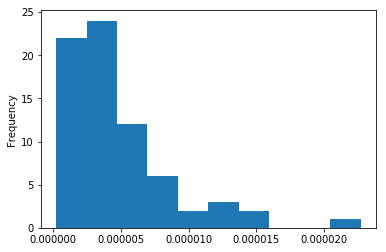

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
Rating['Locations/population'].plot(kind='hist',bins=10)

We can see that Нарьян-Мар with the 0.000023 reading propensity is by far the winning of this part of our rating.    We can also see that there seem to be three types of cities depending on their reading propensity.

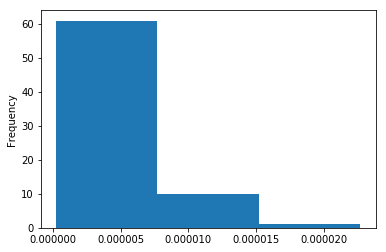

In [126]:
Rating['Locations/population'].plot(kind='hist',bins=3)

We also can affect different colours to the cities according to their reading propensity and visualise the most reading cities (and also the others) on a map.

In [157]:
# Adding in the dataframe the information on the respective bins
Rating['marker_color']=pd.cut(Rating['Locations/population'], bins=3, labels = ['red','yellow','green'])
Rating.head(10)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Город,Регион,Locations/population,lat,lng,Bin,marker_color
37,Нарьян-Мар,Ненецкий АО,0.000023,67.638050,53.006926,"(4.88e-06, 2.27e-05]",green
68,Элиста,Калмыкия,0.000015,46.307743,44.269759,"(4.88e-06, 2.27e-05]",yellow
31,Магадан,Магаданская область,0.000014,59.568164,150.808541,"(4.88e-06, 2.27e-05]",yellow
13,Горно-Алтайск,Алтай,0.000014,51.958182,85.960373,"(4.88e-06, 2.27e-05]",yellow
5,Биробиджан,Еврейская АО,0.000013,48.794668,132.921754,"(4.88e-06, 2.27e-05]",yellow
18,Йошкар-Ола,Марий Эл,0.000012,56.630842,47.886089,"(4.88e-06, 2.27e-05]",yellow
50,Саранск,Мордовия,0.000010,54.187433,45.183938,"(4.88e-06, 2.27e-05]",yellow
54,Сыктывкар,Коми,0.000010,61.668793,50.836399,"(4.88e-06, 2.27e-05]",yellow
56,Тверь,Тверская область,0.000009,56.859611,35.911896,"(4.88e-06, 2.27e-05]",yellow
11,Вологда,Вологодская область,0.000009,59.220496,39.891523,"(4.88e-06, 2.27e-05]",yellow


In [136]:
# Getting Russia's coordinates to generate the map
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode('Russia')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Russia are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Russia are 64.6863136, 97.7453061.


In [164]:
map = folium.Map(location=[latitude, longitude], zoom_start=3)

for index, row in Rating.iterrows():
    folium.CircleMarker([row['lat'], row['lng']],
                    radius=5, color=row['marker_color']).add_to(map)


In [165]:
map

As we can see, no particular macro-region is concentrating relatively high levels of reading propensity. Taking into account the large territory of the country, we can expect that the integration of the data on e-libraries and e-bookstores usage (not covered in the present notebook - see section 1 above) would considerably change the cities' position in this reading rating.